# Bike Sharing!

## Task (Regression): 
Predict the hourly bike rental count based on the environmental and seasonal settings.

In [1]:
# important packages
import numpy as np
import pandas as pd

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# select style
plt.style.use('bmh')

# interactive plots in the backend
import cufflinks as cf
cf.go_offline()


In [2]:
# load the data
df = pd.read_csv('hour.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
# dimensions
df.shape

(17379, 17)

In [4]:
# information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [5]:
def split_data(df):
    """
    A function that splits the variables in a dataframe into numerical and categorical variables.
    It returns a tuple of num_cols, cat_cols
    """
    num_cols = df.select_dtypes(include='number').columns.to_list()
    cat_cols = df.select_dtypes(include='object').columns.to_list()
    return (num_cols, cat_cols)

In [6]:
df1 = df.copy()

# drop the irrelevant columns
df1 = df1.drop(columns=['instant', 'casual', 'registered'])

In [7]:
# split the data into numerical and categorical variables
num_cols, cat_cols = split_data(df1)

# summary statistics of numerical 
df1.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,189.463088
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


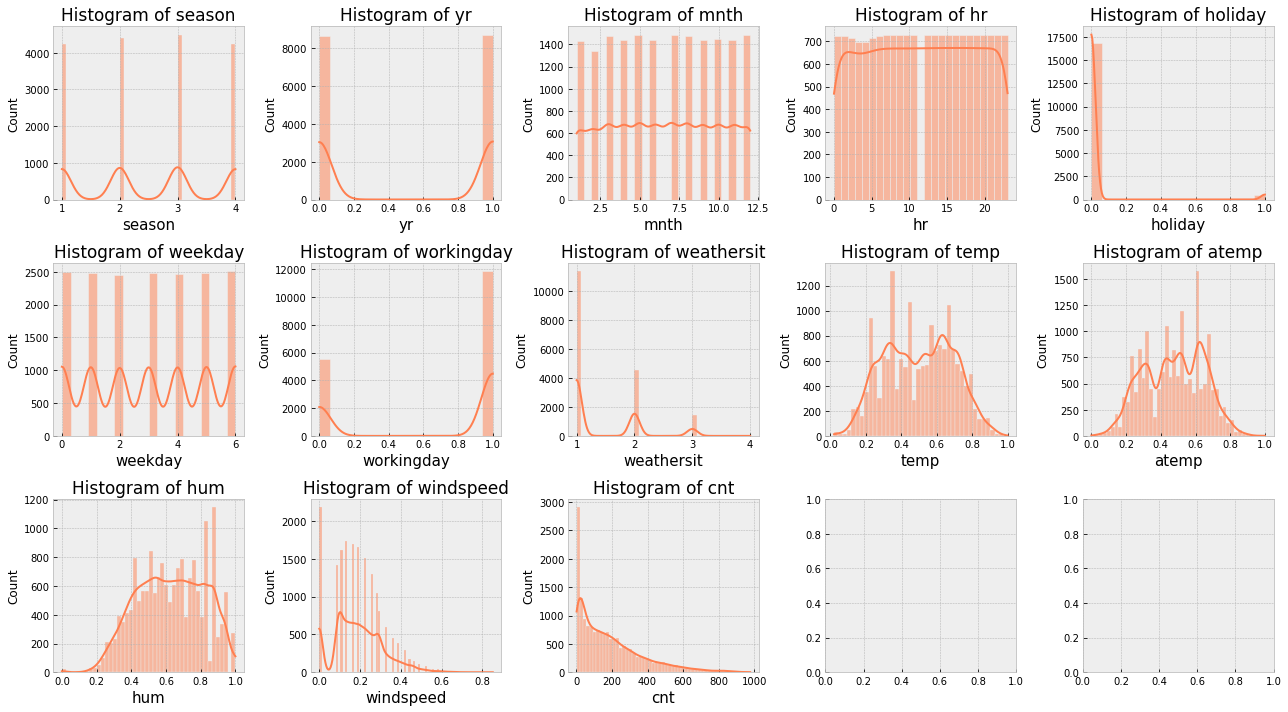

In [8]:
# Histogram of the numerical variables
nrows, ncols = 3, 5

fig, axs = plt.subplots(nrows, ncols, figsize=(6*nrows,2*ncols))

for idx, col in enumerate(num_cols):
    ax = axs[(idx // ncols), (idx % ncols)]
    sns.histplot(data=df1, x=col, kde=True, ax=ax, color='coral')
    ax.set_xlabel(f"{col}", fontsize=15)
    ax.set_title(f"Histogram of {col}", fontsize=17)
    
fig.tight_layout()
plt.show()

**Comment:**
* **'season','yr','mnth','hr','holiday','weekday','workingday','weathersit'** are all categorical variables.
* **'temp', 'atemp', 'hum'** all follow a normal distribution.
* **'windspeed' and 'cnt'** are positively skewed with outliers on the right

In [9]:
def outliers(df, col):
    """A function that returns a range of values that does NOT contain outliers."""
    q1 = np.percentile(df[col], 25)
    q3 = np.percentile(df[col], 75)
    iqr = q3 - q1
    non_outliers = [(q1 - 1.5*iqr), (q3 + 1.5*iqr)]
    
    return non_outliers

In [10]:
df2 = df1.copy()

In [11]:
# range of values
min_v, max_v = outliers(df2, 'windspeed')

# remove the outliers in 'windspeed'
df2 = df2.loc[(df2['windspeed'] >= min_v) & (df2['windspeed'] <= max_v)]

In [12]:
# determine numerical variables to be converted to categorical variables 
cols_to_conv = [col for col in df1 if df1[col].nunique() < 30]   # select columns that have less than 30 unique values

In [13]:
# convert to categorical variables
for col in cols_to_conv:
    df2[col] = df2[col].astype('str') 

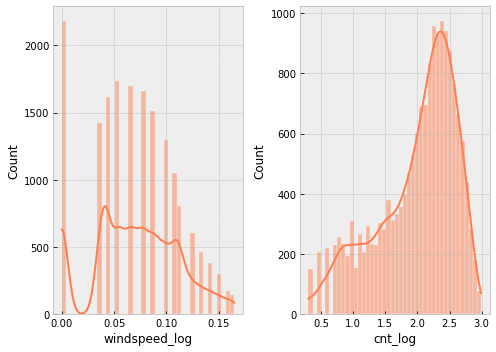

In [14]:
# apply log transformation to reduce the skewness
for col in ['windspeed', 'cnt']:
    df2[f"{col}_log"] = np.log10(df2[col] + 1)

    
# histogram
nrows, ncols = 1, 2

fig, axs = plt.subplots(nrows, ncols, figsize=(7*nrows, 2.5*ncols))

for idx, col in enumerate(['windspeed_log', 'cnt_log']):
    sns.histplot(data=df2, x=col, kde=True, ax=axs[idx], color='coral')
    ax.set_xlabel(f"{col}", fontsize=15)
    ax.set_title(f"Histogram of {col}", fontsize=17)
    
fig.tight_layout()
plt.show()

In [15]:
df3 = df2.copy()

In [16]:
# drop the columns
df3 = df3.drop(columns=['dteday', 'windspeed', 'cnt'])

# split the data into numerical and categorical variables
num_cols, cat_cols = split_data(df3)

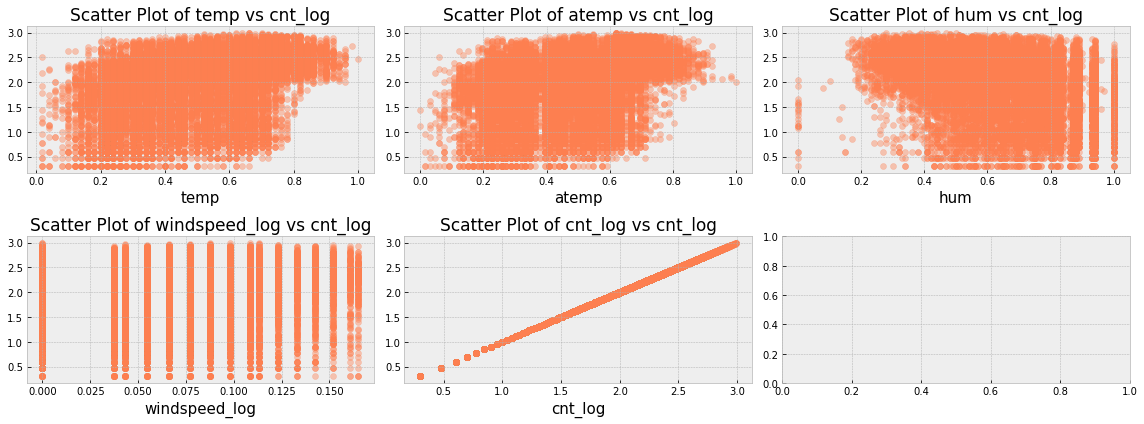

In [17]:
# Scatter Plot of the numerical variables vs target variable
nrows, ncols = 2, 3

fig, axs = plt.subplots(nrows, ncols, figsize=(8*nrows, 2*ncols))

for idx, col in enumerate(num_cols):
    ax = axs[(idx // ncols), (idx % ncols)]
    ax.scatter(col, 'cnt_log', data=df3, alpha=0.4, color='coral')
    ax.set_xlabel(f"{col}", fontsize=15)
    ax.set_title(f"Scatter Plot of {col} vs cnt_log", fontsize=17)
    
fig.tight_layout()
plt.show()

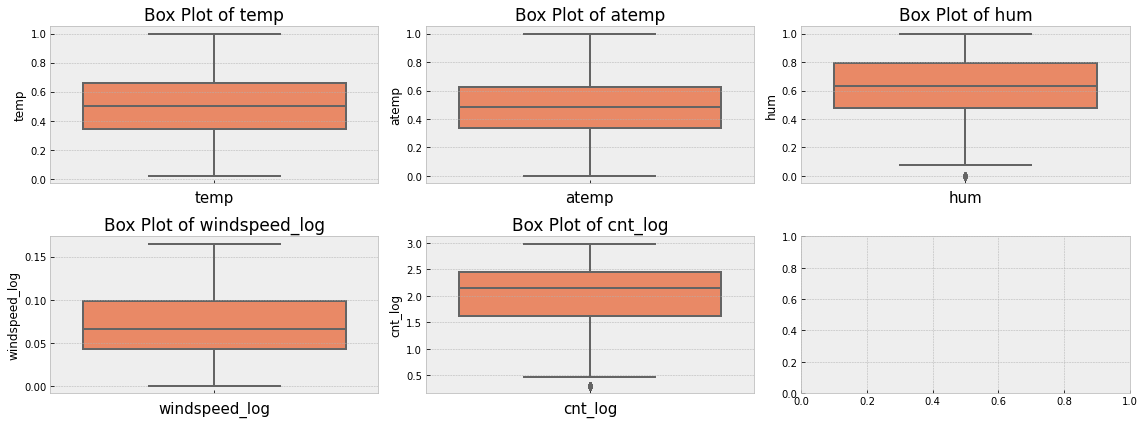

In [18]:
# Box Plot of the numerical variables
nrows, ncols = 2, 3

fig, axs = plt.subplots(nrows, ncols, figsize=(8*nrows, 2*ncols))

for idx, col in enumerate(num_cols):
    ax = axs[(idx // ncols), (idx % ncols)]
    sns.boxplot(data=df3, y=col, ax=ax, color='coral')
    ax.set_xlabel(f"{col}", fontsize=15)
    ax.set_title(f"Box Plot of {col}", fontsize=17)
    
fig.tight_layout()
plt.show()

**Comment:**
* The box shows the number of outliers have reduced.

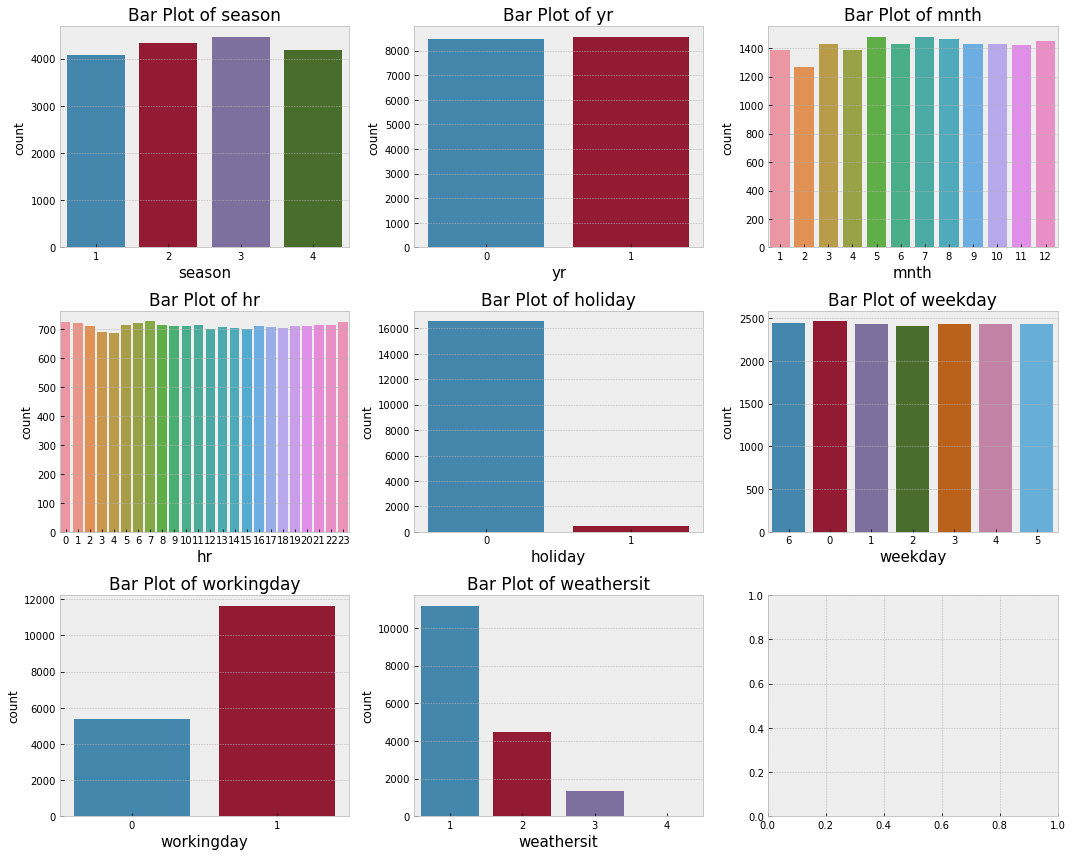

In [19]:
# bar plot of categorical variables
nrows, ncols = 3, 3

fig, axs = plt.subplots(nrows, ncols, figsize=(5*nrows, 4*ncols))

for idx, col in enumerate(cols_to_conv):
    ax = axs[(idx // ncols), (idx % ncols)]
    sns.countplot(data=df3, x=col, ax=ax)
    ax.set_xlabel(f"{col}", fontsize=15)
    ax.set_title(f"Bar Plot of {col}", fontsize=17)
    
fig.tight_layout()
plt.show()

In [20]:
# update the lists containing the numerical and categorical variables
num_cols, cat_cols = split_data(df3)

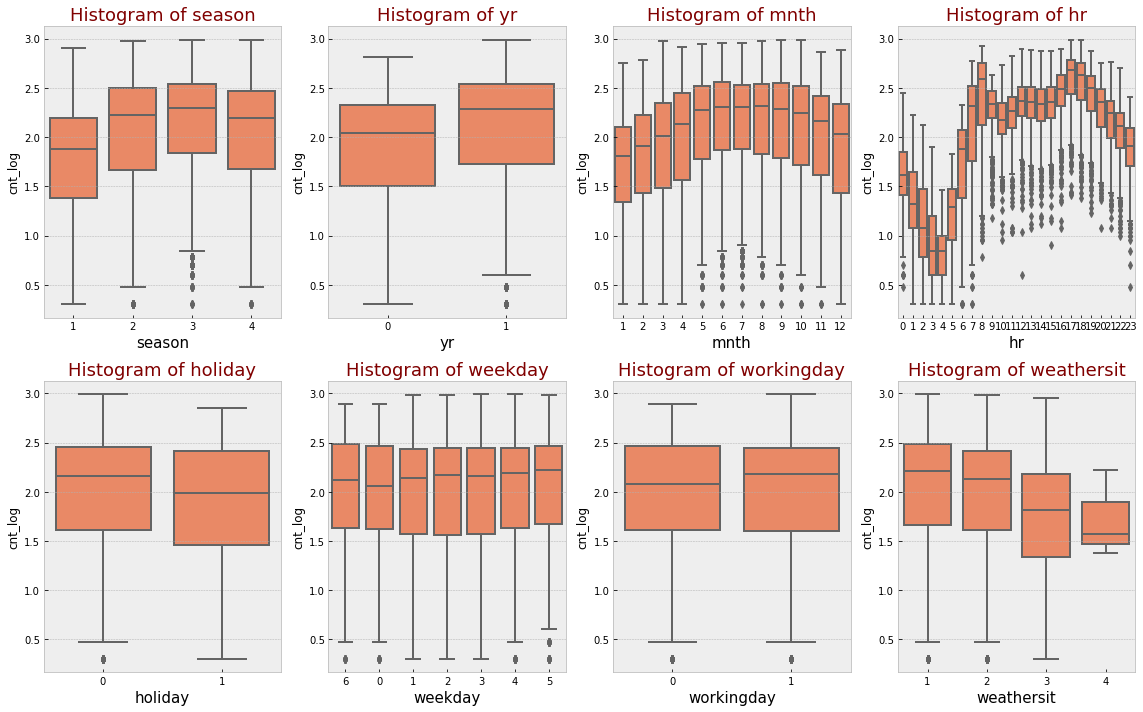

In [21]:
# Box Plot
nrows, ncols = 2, 4

fig, axs = plt.subplots(nrows, ncols, figsize=(8*nrows, 2.5*ncols))

for idx, col in enumerate(cat_cols):
    ax = axs[(idx // ncols), (idx % ncols)]
    sns.boxplot(data=df3, x=col, y='cnt_log', ax=ax, color='coral')
    ax.set_xlabel(f"{col}", fontsize=15)
    ax.set_title(f"Histogram of {col}", fontsize=18, color='maroon')

fig.tight_layout()
plt.show()

**Comment:**

* **Season:** The sum of bike rentals was the highest in 3(fall) and lowest in 1(spring).
* **Year:** The sum of bike rentals was higher in yr 1 (2012).
* **Month:** The sum of bike rentals was higher between months 6 and 8 (June and August) and lower between 1 and 2 (January and February).
* **Hour:** The sum of bike rentals was higher in hr 17 and 18 and was the lowest in the morning (0 to 7).
* **Holiday:** The sum of bike rentals was higher in days that were no holidays.
* **Workingday:** The sum of bike rentals was higher in workingday.
* **Weather:** The sum of bike rentals  reduces as the weathersit increases i.e sum is highest in 'weathersit' 1 and was the lowest in 'weathersit' 4.
<br>

#### Some of the observations made above will be explored below.

In [22]:
df3.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed_log,cnt_log
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,1.230449
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,1.612784
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,1.518514
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,1.146128
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0.301030


In [23]:
# map the year
yr = df3['yr'].map({'0':'2011', '1':'2012'})

# map the season
season = df3['season'].map({'1':'spring', '2':'summer', '3':'fall', '4':'winter'})

# map the month
mnth = df3['mnth'].map({'1':'jan', '2':'feb', '3':'mar', '4':'apr', '5':'may', '6':'jun', '7':'jul', 
                        '8':'aug', '9':'sep', '10':'oct', '11':'nov', '12':'dec'})

# map the weekday
wkday = df3['weekday'].map({'0':'sun','1':'mon', '2':'tue', '3':'wed', '4':'thu', '5':'fri', '6':'sat'})

# map weather situation
weather = df3['weathersit'].map({'1': 'Clear + Partly cloudy', '2':'Mist + Cloudy', 
                                 '3':'Light Snow, Light Rain + Thunderstorm', '4':'Heavy Rain + Ice Pallets'})

In [24]:
# sum of all the bike rentals in 2011 and 2012 grouped by season
a = pd.crosstab(index=season, columns=yr, values=df2['cnt_log'], aggfunc=np.sum)
a = a.sort_values(['2011', '2012'], ascending=False)
a

yr,2011,2012
season,,
fall,4532.885983,4947.440860
summer,4175.330904,4628.136159
winter,4057.246463,4417.433305
spring,3187.062020,3888.452210


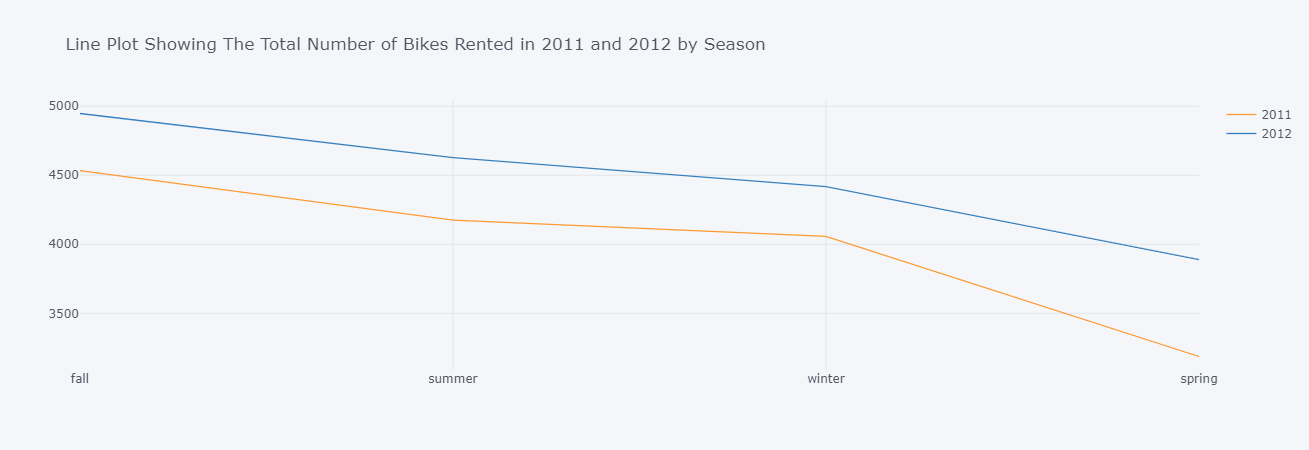

In [25]:
a.iplot(title='Line Plot Showing The Total Number of Bikes Rented in 2011 and 2012 by Season')

In [26]:
# sum of all the bike rentals in 2011 and 2012 grouped by month
a = pd.crosstab(index=mnth, columns=yr, values=df2['cnt_log'], aggfunc=np.sum)
a = a.sort_values(['2011', '2012'], ascending=False)
a

yr,2011,2012
mnth,,
jul,1528.050762,1623.070913
may,1490.953196,1591.680831
jun,1478.133604,1564.880750
aug,1462.955700,1644.111923
sep,1431.064096,1585.472613
oct,1424.028048,1525.820443
nov,1347.343735,1469.297252
dec,1315.843748,1387.555822
apr,1267.958690,1461.527931


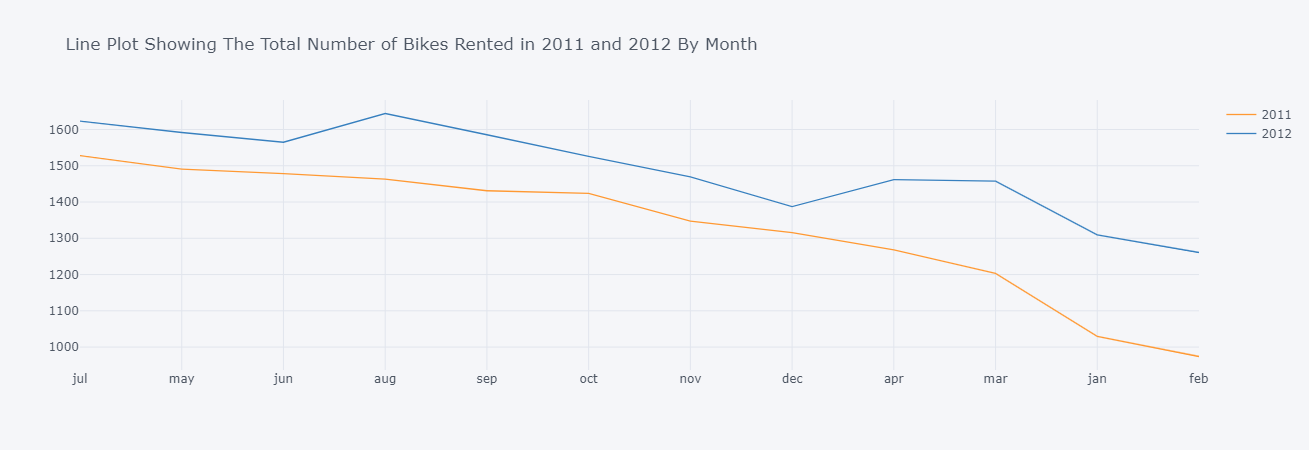

In [27]:
a.iplot(title='Line Plot Showing The Total Number of Bikes Rented in 2011 and 2012 By Month')

In [28]:
# sum of all the bike rentals in 2011 and 2012 grouped by weekday
a = pd.crosstab(index=wkday, columns=yr, values=df2['cnt_log'], aggfunc=np.sum)
a = a.sort_values(['2011', '2012'], ascending=False)
a

yr,2011,2012
weekday,,
fri,2336.368073,2600.006818
sat,2315.986709,2591.593160
sun,2293.561790,2574.343689
mon,2264.911477,2486.035958
thu,2259.699601,2590.688425
tue,2257.381034,2482.077208
wed,2224.616687,2556.717277


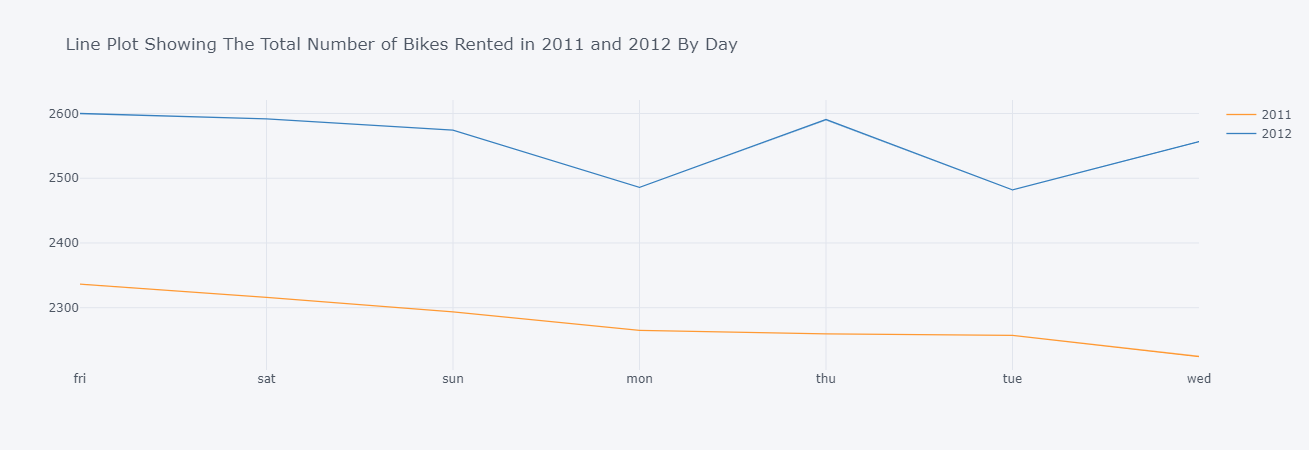

In [29]:
a.iplot(title='Line Plot Showing The Total Number of Bikes Rented in 2011 and 2012 By Day')

In [30]:
# sum of all the bike rentals in 2011 and 2012 grouped by hour
a = pd.crosstab(index=df2['hr'], columns=yr, values=df2['cnt_log'], aggfunc=np.sum)
a = a.sort_values(['2011', '2012'], ascending=False)
a.head()  # preview

yr,2011,2012
hr,,
17,869.687684,959.218707
18,858.064876,938.305958
16,826.087720,898.810781
19,820.654665,902.726332
8,812.639944,910.244925


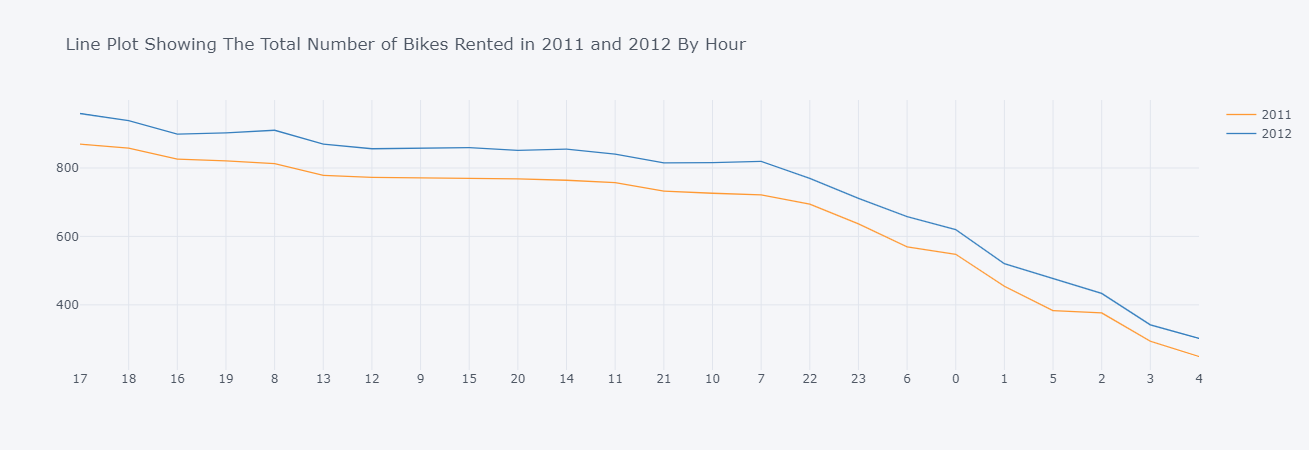

In [31]:
a.iplot(title='Line Plot Showing The Total Number of Bikes Rented in 2011 and 2012 By Hour')

In [32]:
# sum of all the bike rentals in 2011 and 2012 grouped by weather situation
a = pd.crosstab(index=weather, columns=yr, values=df2['cnt_log'], aggfunc=np.sum)
a = a.sort_values(['2011', '2012'], ascending=False)
a

yr,2011,2012
weathersit,,
Clear + Partly cloudy,10614.249547,12050.334869
Mist + Cloudy,4128.384838,4676.406273
"Light Snow, Light Rain + Thunderstorm",1208.322785,1151.123698
Heavy Rain + Ice Pallets,1.568202,3.597695


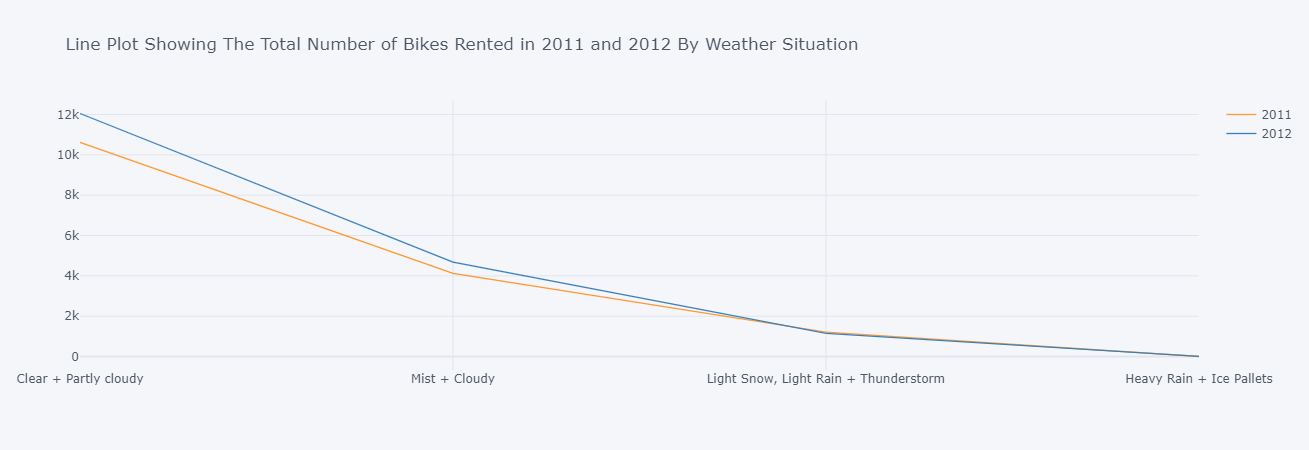

In [33]:
a.iplot(title='Line Plot Showing The Total Number of Bikes Rented in 2011 and 2012 By Weather Situation')

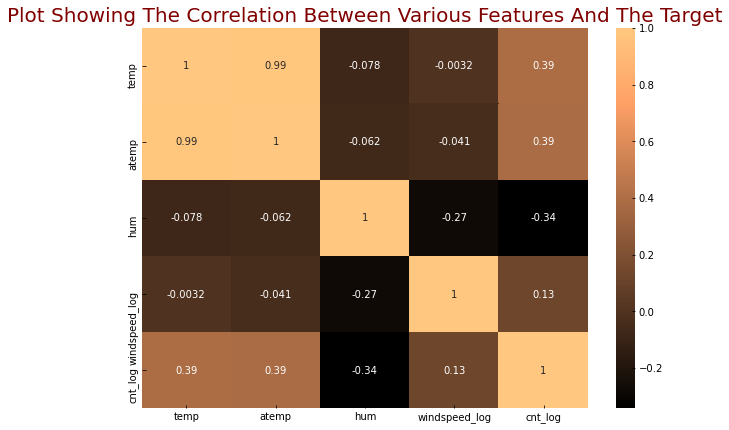

In [34]:
# Correlation matrix
data = df3.corr()
# mask = np.triu(data)

plt.figure(figsize=(10, 7))
sns.heatmap(data=data, annot=True, cmap='copper')
plt.title("Plot Showing The Correlation Between Various Features And The Target", fontsize=20, color='maroon')
plt.show()

In [35]:
# Drop 'atemp' since it's highly correlated with 'temp'
df3 = df3.drop(columns=['atemp'])

#### Standardize the data and build regression model(s)

In [36]:
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sk_m
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [37]:
# independent variable (predictors)
X = df3.drop(columns=['cnt_log'])

# dependent variable (target)
y = df3['cnt_log']

# Scale the data
my_scaler = StandardScaler()
X_scaled = my_scaler.fit_transform(X)

In [38]:
# split the scaled data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)

# Instantiate the model
lin_model = LinearRegression()

# fit the model
lin_model.fit(X_train, y_train)

# make predictions
y_pred = lin_model.predict(X_test)

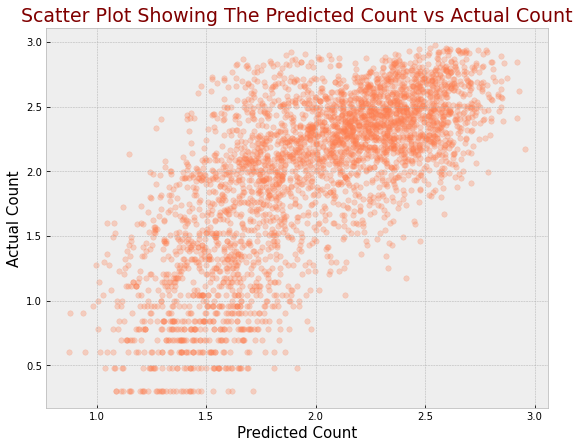

In [39]:
# scatter plot
plt.figure(figsize=(9, 7))
plt.scatter(x=y_pred, y=y_test, alpha=0.3, s=30, color='coral')
plt.xlabel('Predicted Count', fontsize=15)
plt.ylabel('Actual Count', fontsize=15)
plt.title('Scatter Plot Showing The Predicted Count vs Actual Count', fontsize=19, color='maroon')

plt.show()

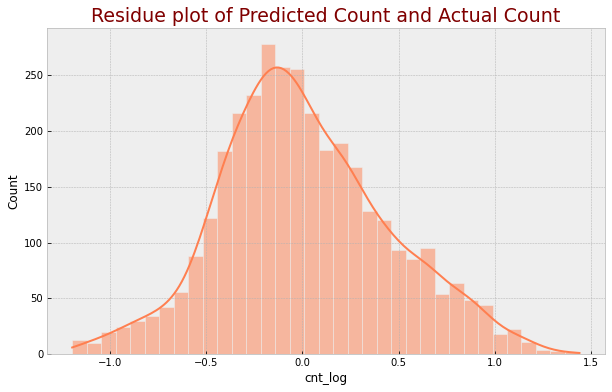

In [40]:
# Residue Plot
residue = y_pred-y_test
plt.figure(figsize=(10, 6))
sns.histplot(x=residue, kde=True, color='coral')
plt.title('Residue plot of Predicted Count and Actual Count', fontsize=19, color='maroon')

plt.show()

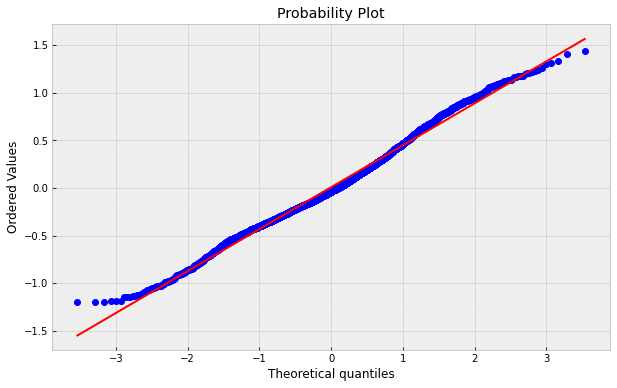

In [41]:
from scipy.stats import probplot
plt.figure(figsize=(10, 6))

probplot(residue, dist='norm', fit=True, plot=plt)
plt.show()

In [42]:
# Model Evaluation
mae = sk_m.mean_absolute_error(y_test, y_pred)
mse = sk_m.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
d = "###" *10


print(f"Mean Abs Error: {mae:.3} \n{d}\nMean Sqd Error: {mse:.3} \n{d}\nRoot Mean Sqd Error: {rmse:.3}")


Mean Abs Error: 0.349 
##############################
Mean Sqd Error: 0.196 
##############################
Root Mean Sqd Error: 0.442


In [43]:
entry_df = pd.DataFrame(columns=X.columns)
# p = [[1, 0, 12, 9, 1, 3, 0, 1, .21, .71, 0]]
p = {'season':1, 'yr':0, 'mnth':12, 'hr':9, 'holiday':1, 'weekday':0, 'workingday':0, 
     'weathersit':1, 'temp':0.21, 'hum':0.71, 'windspeed_log':0}
entry_df = entry_df.append(p, ignore_index=True)
entry_df

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed_log
0,1.0,0.0,12.0,9.0,1.0,0.0,0.0,1.0,0.21,0.71,0.0


In [44]:
scaled_entry = my_scaler.transform(entry_df)

# make predictions
pred = lin_model.predict(scaled_entry)  # value is in log10

# convert the prediction to its actual value \
actual_pred = 10 ** pred
actual_pred = round(actual_pred[0], 2)

print(f"Count in Log: {pred[0]} \nActual Count: {actual_pred} bikes")

Count in Log: 1.2920788300431232 
Actual Count: 19.59 bikes
